# Set up

In [1]:
# Basic imports
import os
import math
import importlib
import random
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data & Feature Generation

In [2]:
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Try multiple ways to get the current learning rate
        lr = None
        
        try:
            # Method 1: For optimizers with a direct lr attribute
            lr = self.model.optimizer.lr
            if hasattr(lr, 'numpy'):
                lr = lr.numpy()
        except AttributeError:
            try:
                # Method 2: For optimizers using a learning_rate attribute
                lr = self.model.optimizer.learning_rate
                if hasattr(lr, 'numpy'):
                    lr = lr.numpy()
            except AttributeError:
                # Method 3: Get from optimizer config
                try:
                    config = self.model.optimizer.get_config()
                    lr = config['learning_rate']
                    if hasattr(lr, 'numpy'):
                        lr = lr.numpy()
                except:
                    lr = "unknown"
        
        print(f"\nLearning rate at epoch {epoch+1}: {lr}")


In [3]:
class OneCycleLR(tf.keras.callbacks.Callback):
    """
    OneCycleLR scheduler compatible with newer TensorFlow versions.
    """
    def __init__(self, 
                 initial_lr=0.001,
                 max_lr=0.01, 
                 min_lr=1e-6, 
                 total_epochs=None, 
                 steps_per_epoch=None,
                 pct_start=0.3,
                 div_factor=25.,
                 final_div_factor=10000.):
        super().__init__()
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        
        # Internal variables
        self.cycle_lr_start = max_lr / div_factor
        self.cycle_lr_end = self.cycle_lr_start / final_div_factor
        self.total_steps = total_epochs * steps_per_epoch
        self.step_size_up = int(self.total_steps * self.pct_start)
        self.step_size_down = self.total_steps - self.step_size_up
        
        self.cycle_iterations = 0
        self.history = []
        
    def on_train_begin(self, logs=None):
        # Initialize with starting learning rate
        # For newer TF versions, we create a LearningRateSchedule
        self._update_learning_rate(self.cycle_lr_start)
    
    def on_batch_end(self, batch, logs=None):
        # Update internal counter
        self.cycle_iterations += 1
        
        # Calculate and set new learning rate
        new_lr = self.calculate_lr()
        self._update_learning_rate(new_lr)
        self.history.append(new_lr)
    
    def _update_learning_rate(self, new_lr):
        """Update the learning rate in a TF version-agnostic way"""
        K = tf.keras.backend
        
        # Try first if we can set the value directly (older TF)
        try:
            lr_tensor = self.model.optimizer.lr
            if hasattr(lr_tensor, 'assign'):
                lr_tensor.assign(new_lr)
            else:
                K.set_value(self.model.optimizer.lr, new_lr)
        except (AttributeError, ValueError):
            # Newer TF: can't directly modify, but we can update learning_rate
            try:
                self.model.optimizer.learning_rate = new_lr
            except AttributeError:
                # Last resort: Get the current optimizer config and create a new one
                config = self.model.optimizer.get_config()
                config['learning_rate'] = new_lr
                # Create a new optimizer with the updated learning rate
                optimizer_name = self.model.optimizer.__class__.__name__
                OptimizerClass = getattr(tf.keras.optimizers, optimizer_name)
                new_optimizer = OptimizerClass.from_config(config)
                # Set the weights of the new optimizer to match the old one
                weights = self.model.optimizer.get_weights()
                new_optimizer.set_weights(weights)
                # Update the model with the new optimizer
                self.model.optimizer = new_optimizer
    
    def calculate_lr(self):
        """Calculate the learning rate for current iteration"""
        # First phase - increasing learning rate
        if self.cycle_iterations <= self.step_size_up:
            return self.annealing_linear(
                self.cycle_iterations,
                self.cycle_lr_start,
                self.max_lr,
                self.step_size_up
            )
        # Second phase - decreasing learning rate
        else:
            down_iteration = self.cycle_iterations - self.step_size_up
            return self.annealing_cos(
                down_iteration,
                self.max_lr,
                self.cycle_lr_end,
                self.step_size_down
            )
    
    def annealing_linear(self, iteration, start_lr, end_lr, total_iterations):
        """Linear annealing from start_lr to end_lr over total_iterations"""
        pct = iteration / total_iterations
        return start_lr + pct * (end_lr - start_lr)
    
    def annealing_cos(self, iteration, start_lr, end_lr, total_iterations):
        """Cosine annealing from start_lr to end_lr over total_iterations"""
        pct = iteration / total_iterations
        cos_pct = (1 + np.cos(np.pi * pct)) / 2
        return end_lr + cos_pct * (start_lr - end_lr)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 1. Data Preparation
# Assuming df is your loaded dataframe
def prepare_data(df):
    features = ["Price", "DXY", "VIX", "DFII10", "EMA30", "EMA252"]
    # Select the relevant columns
    data = df[features].copy().dropna()

    # Normalize the data
    scaler_dict = {}
    for column in data.columns:
        scaler = StandardScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        scaler_dict[column] = scaler
    
    return data, scaler_dict, features

# 2. Create sequences
def create_sequences(data, seq_length, target_column='Price'):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length][target_column]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 3. Define the Transformer model components
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encodings
        pos_encoding = self.positional_encoding(max_seq_length, d_model)
        self.pos_encoding = tf.cast(pos_encoding, tf.float32)
        
    def positional_encoding(self, max_seq_length, d_model):
        positions = tf.range(max_seq_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
        
        # Calculate sine and cosine terms
        pos_encoding = tf.zeros((max_seq_length, d_model))
        indices = tf.range(0, max_seq_length * (d_model // 2)) 
        rows = tf.cast(indices // (d_model // 2), tf.int32)
        cols = tf.cast((indices % (d_model // 2)) * 2, tf.int32)
        
        # Set values for even indices
        sin_values = tf.sin(positions * div_term)
        sin_indices = tf.stack([rows, cols], axis=1)
        sin_updates = tf.reshape(sin_values, [-1])
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, sin_indices, sin_updates)
        
        # Set values for odd indices
        cos_values = tf.cos(positions * div_term)
        cos_indices = tf.stack([rows, cols + 1], axis=1)
        cos_updates = tf.reshape(cos_values, [-1])
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, cos_indices, cos_updates)
        
        return pos_encoding[tf.newaxis, :, :]
        
    def call(self, inputs):
        # Add positional encoding to the input
        seq_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_length, :]

class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1, ff_dim=None):
        super().__init__()
        if ff_dim is None:
            ff_dim = 4 * d_model
            
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
        # Store attention weights
        self.attention_weights = None
        
    def call(self, inputs, training=None, mask=None):
        # Multi-head attention with residual connection and layer normalization
        attn_output, attention_weights = self.mha(
            inputs, inputs, 
            return_attention_scores=True,
            attention_mask=mask
        )
        
        # Store attention weights for later analysis
        self.attention_weights = attention_weights
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class GoldPriceTransformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=8, 
                 num_layers=3, dropout_rate=0.1):
        super().__init__()
        
        self.input_projection = tf.keras.layers.Dense(d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.encoder_layers = [
            TransformerEncoderLayer(d_model, num_heads, dropout_rate) 
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_projection = tf.keras.layers.Dense(output_dim)
        
    def call(self, inputs, training=None, mask=None):
        # inputs shape: [batch_size, seq_len, input_dim]
        x = self.input_projection(inputs)
        x = self.positional_encoding(x)
        x = self.dropout(x, training=training)
        
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training, mask=mask)
            
        # Extract the last time step for forecasting
        final_output = x[:, -1, :]
        return self.output_projection(final_output)

# 4. Feature Importance Analysis
def analyze_feature_importance(model, X_test, y_test, feature_names):
    """
    Analyze feature importance using permutation importance
    """
    # Get baseline predictions
    baseline_preds = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # Calculate importance by permuting each feature
    feature_importance = []
    
    for i in range(X_test.shape[2]):  # For each feature
        # Create a copy of the test data
        X_permuted = X_test.copy()
        
        # Permute the feature (shuffle its values)
        permuted_values = np.random.permutation(X_permuted[:, :, i].flatten())
        X_permuted[:, :, i] = permuted_values.reshape(X_permuted[:, :, i].shape)
        
        # Get predictions with permuted feature
        permuted_preds = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y_test, permuted_preds)
        
        # Calculate importance (how much worse the model performs without this feature)
        importance = permuted_mse - baseline_mse
        feature_importance.append(importance)
    
    # Normalize to get relative importance
    if sum(feature_importance) > 0:
        feature_importance = [max(0, imp) for imp in feature_importance]  # Force positive values
        feature_importance = [imp / sum(feature_importance) for imp in feature_importance]
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Relative Importance')
    plt.title('Feature Importance (Permutation Method)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def visualize_time_attention(model, X_sample):
    """
    Visualize which time steps the model is paying most attention to
    """
    # We need to run a forward pass to get attention weights
    _ = model(tf.convert_to_tensor(X_sample[np.newaxis, ...], dtype=tf.float32))
    
    # Extract attention weights from the last layer
    attention_weights = model.encoder_layers[-1].attention_weights
    
    # Average across heads to get one weight per timestep
    # Shape will be [batch, seq_len, seq_len]
    avg_weights = tf.reduce_mean(attention_weights, axis=1)[0]
    
    # The last row shows how much attention the prediction (last timestep) 
    # pays to each input timestep
    last_timestep_weights = avg_weights[-1, :].numpy()
    
    # Plot attention over time
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(last_timestep_weights)), last_timestep_weights)
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    plt.title('Attention Distribution Across Time Steps')
    
    # Add marker for significant time points
    plt.axhline(y=np.mean(last_timestep_weights), color='r', linestyle='--', 
                label='Average Attention')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also create a heatmap for all timesteps
    plt.figure(figsize=(10, 8))
    plt.imshow(avg_weights, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Input Time Step')
    plt.ylabel('Output Time Step')
    plt.title('Full Attention Matrix')
    plt.tight_layout()
    plt.show()
    
    return last_timestep_weights

# 5. Trading Strategy Backtest
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# 6a. Directional MSE Loss
def directional_mse_loss(alpha=0.5):
    def loss(y_true, y_pred):
        # Calculate MSE component manually
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # For directional component, we need to reshape y_true and y_pred
        # as they are 1D in your backtesting context
        # Get true values for current and previous time steps
        y_true_current = y_true[1:]
        y_true_prev = y_true[:-1]
        
        # Get predicted values for current and previous time steps
        y_pred_current = y_pred[1:]
        y_pred_prev = y_pred[:-1]
        
        # Calculate directional component
        true_diff = y_true_current - y_true_prev
        pred_diff = y_pred_current - y_pred_prev
        
        # Get signs of differences
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        
        # Calculate direction agreement (1 when directions match, 0 otherwise)
        dir_agree = tf.cast(tf.equal(true_sign, pred_sign), tf.float32)
        dir_loss = 1.0 - tf.reduce_mean(dir_agree)
        
        # Combine losses with weighting factor alpha
        return alpha * mse + (1 - alpha) * dir_loss
    
    return loss

# 7. Main Backtesting Process
def run_gold_price_backtesting(df, seq_length=60, test_size=0.2, 
                              d_model=64, num_heads=4, num_layers=2, 
                              dropout_rate=0.1, batch_size=32, epochs=50,
                              use_one_cycle_lr=True, max_lr=0.01, min_lr=1e-6,
                              directional_loss_weight=0.5):
    """
    Complete backtesting process for gold price prediction
    """
    # 1. Prepare data
    data, scaler_dict, features = prepare_data(df)
    price_scaler = scaler_dict['Price']
    
    # 2. Create sequences
    X, y = create_sequences(data, seq_length)
    
    # 3. Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # 4. Initialize the model
    input_dim = X_train.shape[2]
    output_dim = 1
    
    model = GoldPriceTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    )
    
    # 5. Compile the model
    initial_lr = 0.001

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=directional_mse_loss(alpha=1-directional_loss_weight)
    )
    
    # 6. Define callbacks
    callbacks = []
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    callbacks.append(early_stopping)
    
    # Add model checkpoint
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'gold_transformer_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
    callbacks.append(model_checkpoint)

    # Calculate steps per epoch for OneCycleLR
    steps_per_epoch = np.ceil(len(X_train) / batch_size)

    # Learning rate scheduler
    lr_scheduler = None
    if use_one_cycle_lr:
        lr_scheduler = OneCycleLR(
            initial_lr=initial_lr,
            max_lr=max_lr,
            min_lr=min_lr,
            total_epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.3  # Use 30% of training for warmup
        )
        callbacks.append(lr_scheduler)
    
    # Add LR history logger
    callbacks.append(LRLogger())
    
    # 7. Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # 8. Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # 9. Denormalize predictions and actual values
    y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()
    
    # 10. Calculate performance metrics
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    r2 = r2_score(y_test_denorm, y_pred_denorm)
    
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test R²: {r2:.4f}")
    
    # 11. Calculate directional accuracy
    def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100
    
    da = directional_accuracy(y_test_denorm, y_pred_denorm)
    print(f"Directional Accuracy: {da:.2f}%")
    
    # 12. Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(y_test_denorm[-100:], label='Actual', color='blue')
    plt.plot(y_pred_denorm[-100:], label='Predicted', color='red')
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.title('Last 100 Predictions')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the learning rate history if OneCycleLR was used
    if use_one_cycle_lr and lr_scheduler:
        plt.figure(figsize=(12, 4))
        plt.plot(lr_scheduler.history)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('OneCycleLR Learning Rate Schedule')
        plt.grid(True)
        plt.show()
    
    # 13. Feature importance analysis
    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(model, X_test, y_test, features)
    
    # 14. Time attention visualization
    print("\nVisualizing attention over time...")
    time_attention = visualize_time_attention(model, X_test[0])
    
    # 15. Trading strategy backtest
    print("\nRunning trading strategy backtest...")
    trades, equity_curve = backtest_trading_strategy(y_test_denorm, y_pred_denorm)
    
    # Return everything for further analysis
    results = {
        'model': model,
        'history': history,
        'y_test': y_test_denorm,
        'y_pred': y_pred_denorm,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': da
        },
        'feature_importance': feature_importance,
        'time_attention': time_attention,
        'trading_results': {
            'trades': trades,
            'equity_curve': equity_curve
        }
    }
    
    return results

# To use the backtesting framework:
# 1. Load your dataframe
# 2. Run the backtesting process
# results = run_gold_price_backtesting(df)

In [18]:
def find_optimal_lr(df, seq_length=60, test_size=0.2, 
                   d_model=64, num_heads=4, num_layers=2,
                   dropout_rate=0.1, batch_size=32,
                   start_lr=1e-7, end_lr=1.0, num_steps=100):
    """
    Find the optimal learning rate using an exponential increase
    """
    # Prepare data as in regular backtesting
    data, scaler_dict, features = prepare_data(df)
    X, y = create_sequences(data, seq_length)
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Create validation set from the end of the training data
    val_size = int(len(X_train) * 0.2)
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    
    # Initialize the model
    input_dim = X_train.shape[2]
    output_dim = 1
    
    # Prepare for LR finder
    lr_values = np.geomspace(start_lr, end_lr, num_steps)
    losses = []
    
    # Run training with increasing learning rates
    print("Finding optimal learning rate...")
    for i, lr in enumerate(lr_values):
        # Create a new model for each learning rate to ensure clean state
        K = tf.keras.backend
        K.clear_session()
        
        model = GoldPriceTransformer(
            input_dim=input_dim, output_dim=output_dim,
            d_model=d_model, num_heads=num_heads,
            num_layers=num_layers, dropout_rate=dropout_rate
        )
        
        # Create optimizer with current learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=float(lr))
        
        # Compile the model
        model.compile(optimizer=optimizer, loss='mse')
        
        # Train for one batch
        history = model.fit(
            X_train[:batch_size], y_train[:batch_size],
            epochs=1, batch_size=batch_size, verbose=0
        )
        
        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        losses.append(val_loss)
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Step {i+1}/{num_steps}, LR: {lr:.8f}, Loss: {val_loss:.6f}")
        
        # Stop if loss is exploding
        if not np.isfinite(val_loss) or (i > 0 and val_loss > 10*losses[0]):
            print("Stopping early due to diverging loss")
            break
    
    # Plot the learning rate vs. loss
    plt.figure(figsize=(12, 6))
    plt.plot(lr_values[:len(losses)], losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.grid(True)
    
    # Find the point of steepest descent (where the loss is decreasing the fastest)
    grad = np.gradient(losses)
    smoothed_grad = np.convolve(grad, np.ones(5)/5, mode='same')  # Smooth gradient
    
    # Find where gradient is steepest (most negative)
    # Avoid the very beginning and end of the curve
    start_idx = min(10, len(smoothed_grad)//10)
    valid_idx = slice(start_idx, len(smoothed_grad)-5)
    min_grad_idx = valid_idx.start + np.argmin(smoothed_grad[valid_idx])
    
    if min_grad_idx >= len(lr_values):
        min_grad_idx = len(lr_values) - 1
        
    suggested_lr = lr_values[min_grad_idx]
    
    plt.axvline(x=suggested_lr, color='r', linestyle='--')
    plt.text(suggested_lr*1.1, np.median(losses), 
             f'Suggested LR: {suggested_lr:.6f}', color='r')
    
    plt.show()
    
    return suggested_lr


In [6]:
# # Find the optimal learning rate
# optimal_lr = find_optimal_lr(df)
# print(f"Optimal learning rate: {optimal_lr:.6f}")

Training data shape: (4543, 60, 6)
Testing data shape: (1136, 60, 6)
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0980


Learning rate at epoch 1: 9.138027934341153e-08
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 1.0980 - val_loss: 0.8713
Epoch 2/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0597


Learning rate at epoch 2: 1.4276056958806294e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0596 - val_loss: 0.8372
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0009


Learning rate at epoch 3: 1.9414083851643227e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0009 - val_loss: 0.7922
Epoch 4/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9638


Learning rate at epoch 4: 2.4552113586651103e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.9642 - val_loss: 0.7352
Epoch 5/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9254


Learning rate at epoch 5: 2.969014190057351e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.9254 - val_loss: 0.6766
Epoch 6/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8569


Learning rate at epoch 6: 3.4828170214495913e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.8571 - val_loss: 0.6167
Epoch 7/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7898


Learning rate at epoch 7: 3.996619852841832e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.7898 - val_loss: 0.5600
Epoch 8/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7513


Learning rate at epoch 8: 4.510422400016978e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.7506 - val_loss: 0.5073
Epoch 9/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6940


Learning rate at epoch 9: 5.024225515626313e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.6936 - val_loss: 0.4637
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6181


Learning rate at epoch 10: 5.538028062801459e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6179 - val_loss: 0.4282
Epoch 11/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5766


Learning rate at epoch 11: 6.051831178410794e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5765 - val_loss: 0.3974
Epoch 12/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5178


Learning rate at epoch 12: 6.56563372558594e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.5180 - val_loss: 0.3735
Epoch 13/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5099


Learning rate at epoch 13: 7.079436841195275e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5096 - val_loss: 0.3550
Epoch 14/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4500


Learning rate at epoch 14: 7.593239388370421e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4502 - val_loss: 0.3403
Epoch 15/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4042


Learning rate at epoch 15: 8.107042503979756e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.4043 - val_loss: 0.3302
Epoch 16/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3998


Learning rate at epoch 16: 8.620845051154902e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3998 - val_loss: 0.3233
Epoch 17/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3451


Learning rate at epoch 17: 9.134648166764237e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3457 - val_loss: 0.3169
Epoch 18/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3515


Learning rate at epoch 18: 9.648450713939383e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3516 - val_loss: 0.3111
Epoch 19/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3183


Learning rate at epoch 19: 9.998705081670778e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.3185 - val_loss: 0.3096
Epoch 20/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2895


Learning rate at epoch 20: 9.977541139960522e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2899 - val_loss: 0.3064
Epoch 21/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3204


Learning rate at epoch 21: 9.930541864378029e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.3202 - val_loss: 0.3038
Epoch 22/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3083


Learning rate at epoch 22: 9.857949407887645e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3083 - val_loss: 0.3010
Epoch 23/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2836


Learning rate at epoch 23: 9.760143484527362e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2836 - val_loss: 0.2976
Epoch 24/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2747


Learning rate at epoch 24: 9.637628863856662e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2748 - val_loss: 0.2927
Epoch 25/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2683
Learning rate at epoch 25: 9.491043329035165e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2686 - val_loss: 0.2933
Epoch 26/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2653


Learning rate at epoch 26: 9.321146876573039e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2654 - val_loss: 0.2922
Epoch 27/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2675


Learning rate at epoch 27: 9.128822284765192e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2676 - val_loss: 0.2894
Epoch 28/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2703


Learning rate at epoch 28: 8.915066587178444e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2703 - val_loss: 0.2877
Epoch 29/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2642


Learning rate at epoch 29: 8.680989935783145e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2644 - val_loss: 0.2864
Epoch 30/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2447
Learning rate at epoch 30: 8.427807074440352e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2450 - val_loss: 0.2865
Epoch 31/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2405
Learning rate at epoch 31: 8.156832791428315e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2405 - val_loss: 0.2871
Epoch 32/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2603
Learning rate at epoch 32: 7.86947282449546e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2602 - val_loss: 0.2875
Epoch 33/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2453
Learning rate at epoch 33: 7.567218744952697e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.2454 - val_loss: 0.2878
Epoch 34/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2515
Learning rate at epoch 34: 7.2


Learning rate at epoch 37: 6.241627374947711e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2341 - val_loss: 0.2848
Epoch 38/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2289


Learning rate at epoch 38: 5.889691010452225e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2291 - val_loss: 0.2847
Epoch 39/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2335


Learning rate at epoch 39: 5.533136686608486e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2336 - val_loss: 0.2836
Epoch 40/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2211
Learning rate at epoch 40: 5.173814656700415e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2212 - val_loss: 0.2836
Epoch 41/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2210
Learning rate at epoch 41: 4.813591090169211e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2212 - val_loss: 0.2841
Epoch 42/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2310


Learning rate at epoch 42: 4.4543349986270186e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2312 - val_loss: 0.2828
Epoch 43/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2180
Learning rate at epoch 43: 4.09791141464666e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2181 - val_loss: 0.2834
Epoch 44/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2247


Learning rate at epoch 44: 3.7461703072949604e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2247 - val_loss: 0.2824
Epoch 45/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2399
Learning rate at epoch 45: 3.4009369187515404e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2398 - val_loss: 0.2825
Epoch 46/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2268
Learning rate at epoch 46: 3.0640038062301755e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2269 - val_loss: 0.2824
Epoch 47/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2213
Learning rate at epoch 47: 2.7371194732950244e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2215 - val_loss: 0.2824
Epoch 48/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2188


Learning rate at epoch 48: 2.421980980216176e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.2189 - val_loss: 0.2820
Epoch 49/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2285
Learning rate at epoch 49: 2.1202234279371623e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2285 - val_loss: 0.2822
Epoch 50/50
112/114 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2186


Learning rate at epoch 50: 1.8334137052988808e-07
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2187 - val_loss: 0.2816
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Test MSE: 5265.47
Test RMSE: 72.56
Test MAE: 51.56
Test R²: 0.9236
Directional Accuracy: 47.58%


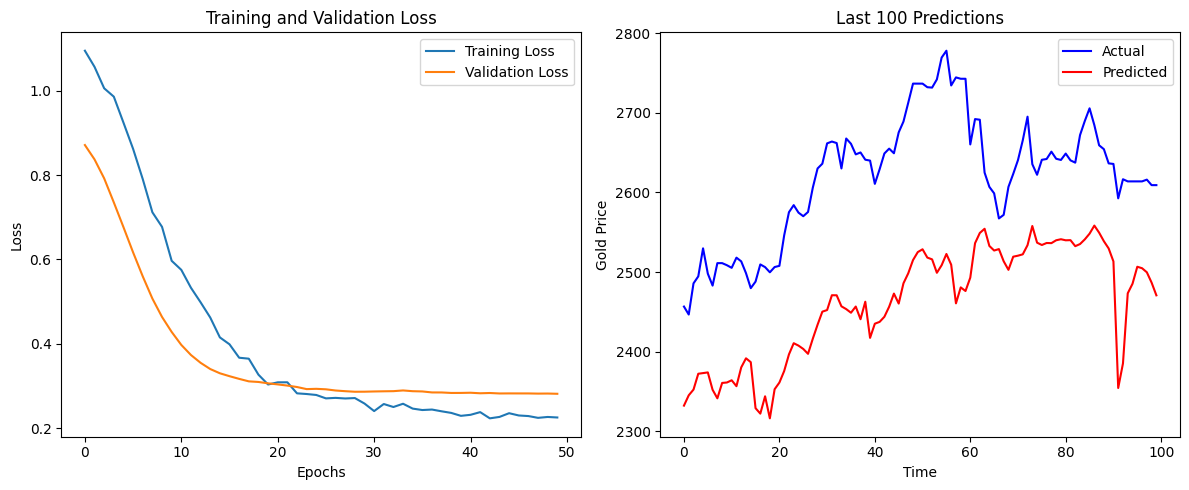

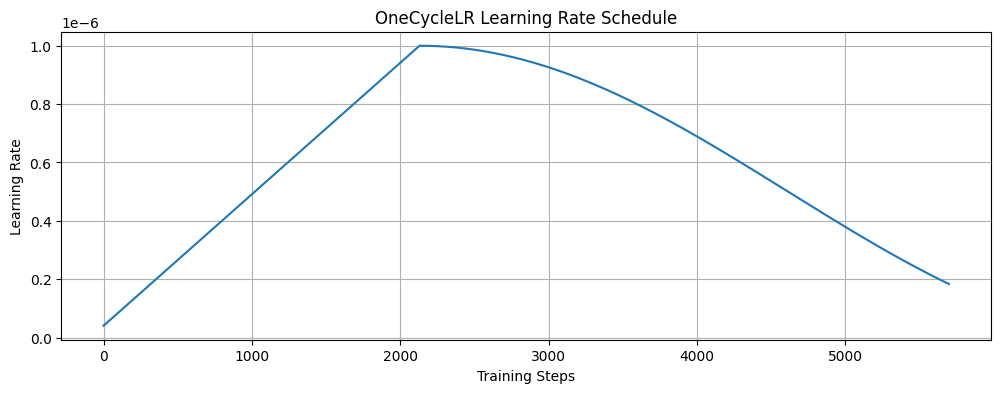


Analyzing feature importance...
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


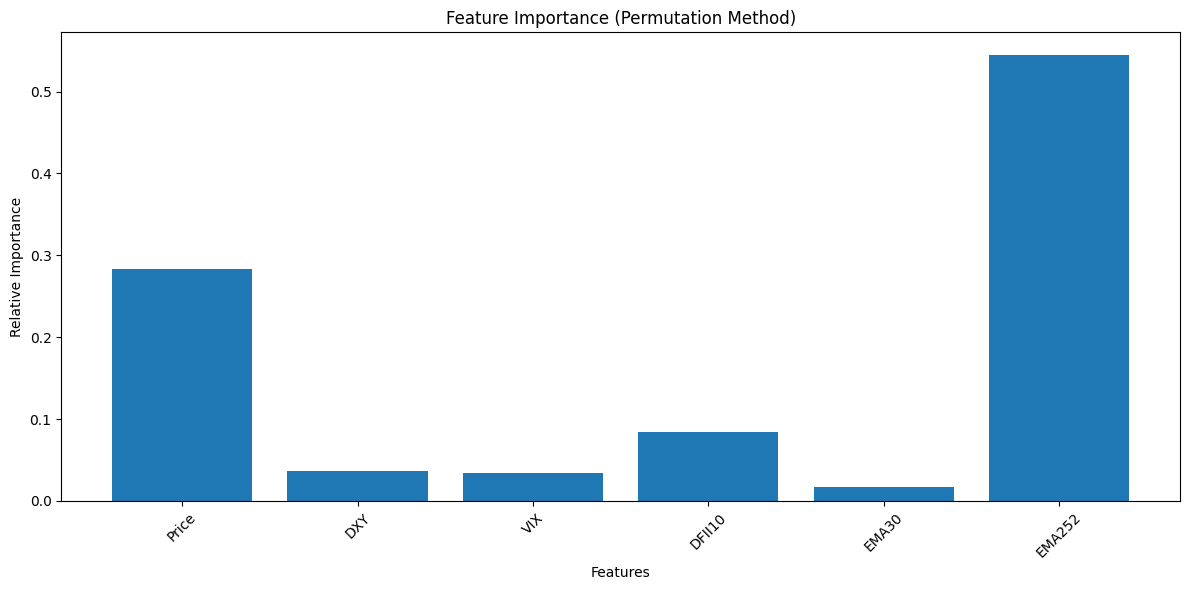


Visualizing attention over time...


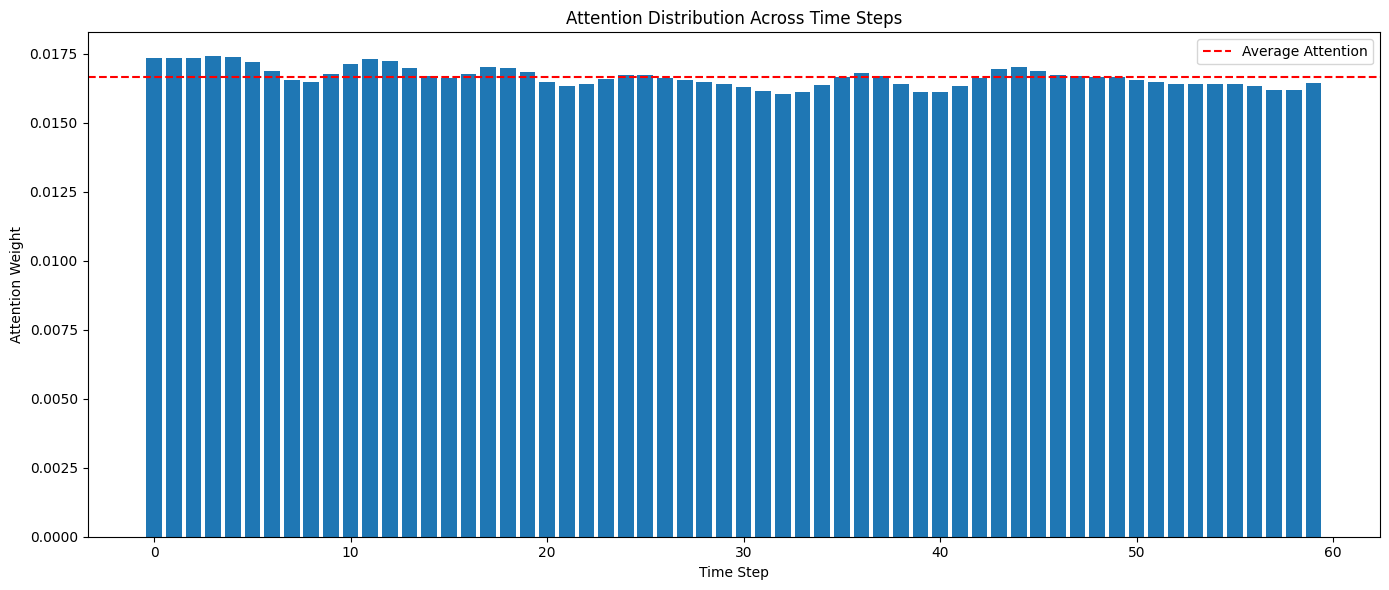

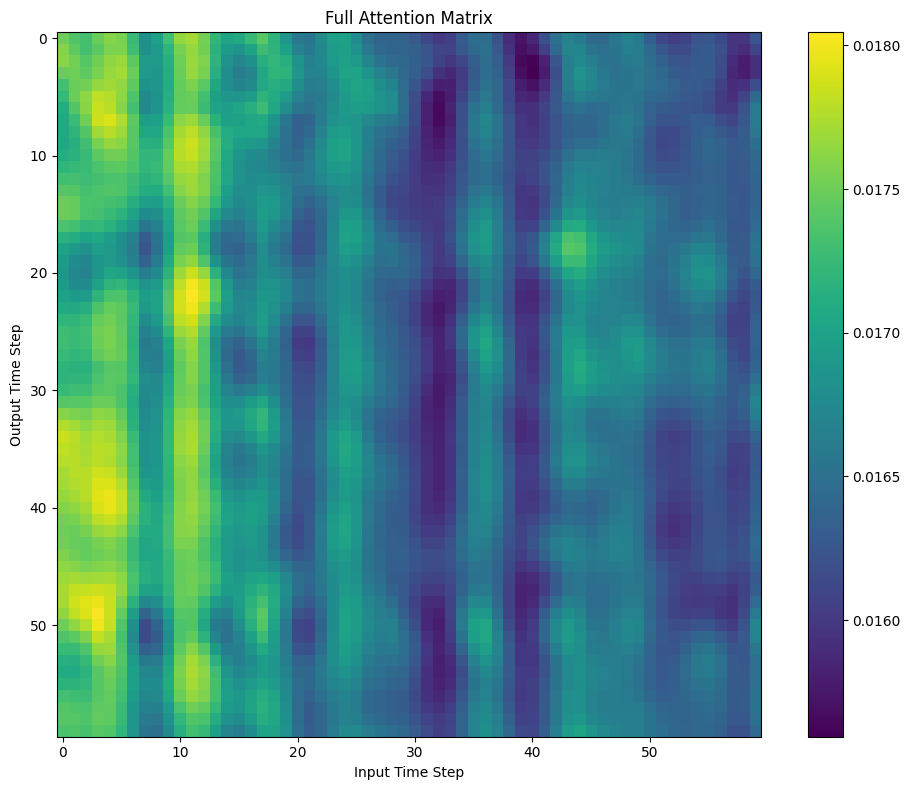


Running trading strategy backtest...


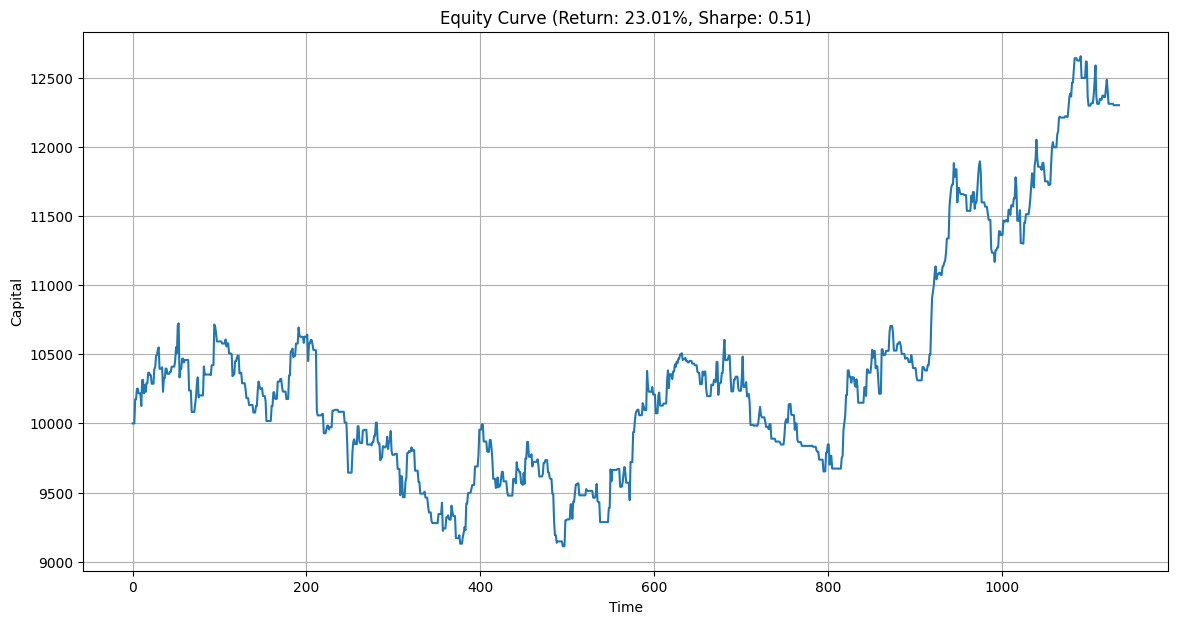

Final capital: $12301.27
Return: 23.01%
Sharpe Ratio: 0.51
Number of trades: 287
RMSE: 72.56
Directional Accuracy: 47.58%


In [19]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=64,             # Dimension of transformer model
    num_heads=4,            # Number of attention heads
    num_layers=2,           # Number of transformer layers
    use_one_cycle_lr=True,
    max_lr=0.000001,
    min_lr=1e-6,
    dropout_rate=0.1,       # Dropout rate for regularization
    batch_size=32,          # Batch size for training
    epochs=50,              # Maximum number of training epochs
    directional_loss_weight=0.5
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
model.save('gold_price_transformer.keras')
